### NYC YELLOW TAXI DATA ANALYSIS

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as s

import datetime as dt
#from tabulate import tabulate 
from shapely.geometry import Point,Polygon,MultiPoint,MultiPolygon

from sklearn.preprocessing import normalize, scale
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import  mean_squared_error, r2_score
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#from mapsplotlib import mapsplot as mplt

ModuleNotFoundError: No module named 'shapely'

In [3]:
os.chdir('/Users/nishitpatel/Desktop/UIUC MCS-DS/CS-498 - Cloud Computing Applications - SPRING 2018/project/')

In [4]:
import os
os.getcwd()

'/Users/nishitpatel/Desktop/UIUC MCS-DS/CS-498 - Cloud Computing Applications - SPRING 2018/Project'

In [5]:
#load the data file
import warnings
warnings.filterwarnings("ignore")

# read the data file
file = 'nyc_taxi_data.csv'
taxi_dt = pd.read_csv(file)

print(taxi_dt.shape)

(3100378, 22)


#### Performing data quality checks

In [ ]:
#print dataset dimensions
print("number of observations:", taxi_dt.shape[0])
print( "number of variables:", taxi_dt.shape[1])
print(taxi_dt.shape)

#print variable datatypes
print(taxi_dt.dtypes)

#check missing values
taxi_dt.isnull().sum()

#print sample data 
print(taxi_dt.head(10))

#print statistics for each variables
taxi_dt.describe()

#standard daviation of each column 
taxi_dt.std()

"""
#pairs plot 
taxi_frame = taxi_dt[['trip_distance','rate_code','passenger_count','trip_time','payment_type','fare_amount']]
taxi_pplot = s.pairplot(taxi_frame)
taxi_pplot
""""

number of observations: 3100378
number of variables: 22
(3100378, 22)
medallion             object
hack_license          object
vendor_id              int64
rate_code              int64
pickup_date           object
pickup_time           object
dropoff_date          object
dropoff_time          object
passenger_count        int64
trip_time              int64
trip_distance        float64
pickup_longtidue     float64
pickup_lattitude     float64
dropoff_longitude    float64
dropoff_lattitude    float64
payment_type           int64
fare_amount          float64
surcharge            float64
mta_tax              float64
tip_amount           float64
tolls_amount         float64
total_amount         float64
dtype: object
                          medallion                      hack_license  \
0  1F50D5BADD3FCE069B55E2CFAE1501BC  C323843290235F0ADC1A5F9F7C012812   
1  035A25BC8C3C1868838AD8DC880DE0F6  D35F7DBF6BBA611225ACD35DF0413930   
2  484CE29A8A46C08FA10112930B57BFCB  8ABFC6FBF2871AFA27A868

#### Exploratory Data Analysis

Text(0.5,1,'Histogram of Trip Distance')

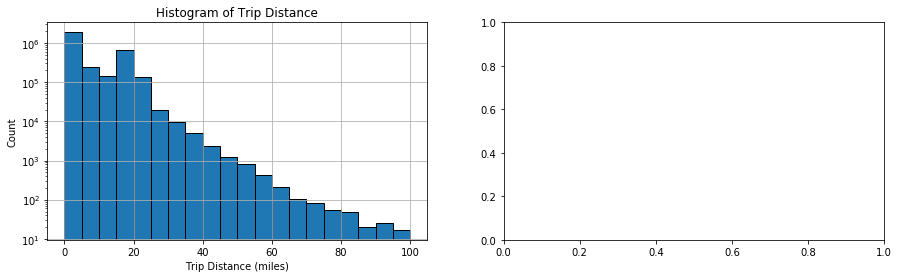

In [6]:
# Distribution of trip distances
# define the figure with 2 subplots
fig,ax = plt.subplots(1,2,figsize = (15,4)) 

# histogram of the number of trip distance
taxi_dt.trip_distance.hist(bins=20,ax=ax[0], edgecolor='black')
ax[0].set_xlabel('Trip Distance (miles)')
ax[0].set_ylabel('Count')
ax[0].set_yscale('log')
ax[0].set_title('Histogram of Trip Distance')

In [8]:
# create a vector to contain Trip Distance
v = taxi_dt.trip_distance 
# exclude any data point located further than 3 standard deviations of the median point and 
# v[~((v-v.median()).abs()>3*v.std())].hist(bins=20,ax=ax[1], edgecolor='black') 
ax[1].set_xlabel('Trip Distance (miles)')
ax[1].set_ylabel('Count')
ax[1].set_title('A. Histogram of Trip Distance (without outliers)')

# apply a lognormal fit. Use the mean of trip distance as the scale parameter
scatter,loc,mean = lognorm.fit(taxi_dt.trip_distance.values,
                               scale=taxi_dt.trip_distance.mean(),
                               loc=0)
pdf_fitted = lognorm.pdf(np.arange(0,12,.1),scatter,loc,mean)
ax[1].plot(np.arange(0,12,.1),600000*pdf_fitted,'r') 
ax[1].legend(['data','lognormal fit'])
plt.show()

NameError: name 'lognorm' is not defined

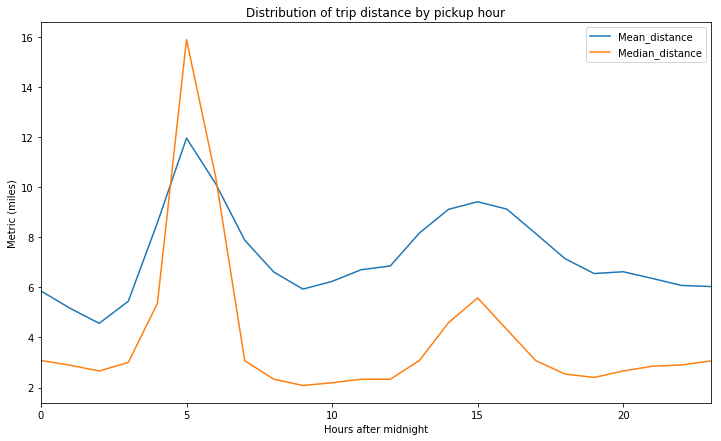

In [9]:
# Distribution of trip distance by pickup hour
# Q: does time of the day affect the taxi ridership?
taxi_dt['pickup_hour'] = taxi_dt['pickup_time'].str[:2]

fix, axis = plt.subplots(1,1,figsize=(12,7))
#aggregate trip_distance by hour for plotting
tab = taxi_dt.pivot_table(index='pickup_hour', values='trip_distance', aggfunc=('mean','median')).reset_index()
     
tab.columns = ['Hour','Mean_distance','Median_distance']
tab[['Mean_distance','Median_distance']].plot(ax=axis)
plt.ylabel('Metric (miles)')
plt.xlabel('Hours after midnight')
plt.title('Distribution of trip distance by pickup hour')
plt.xlim([0,23])
plt.show()

Plot is suggesting that the mean trip distances is longer in morning and evening hours. This could be the population that uses cabs to commute for
work. But if so the the evening commuter are much less than morning commuters. This indicates that the people who takes taxi in the morning to work 
do not use it when they go back home. Hypothetically this makes sense as people do not want to get late to work. Other hypothesis is there are usually
large number of people who take flights during morning and evening. This could also be a contributing factor that pushes the mean higher that other time
of the day. To prove that, we will now take a look at the airport and non-airport taxi rides and its distribution.

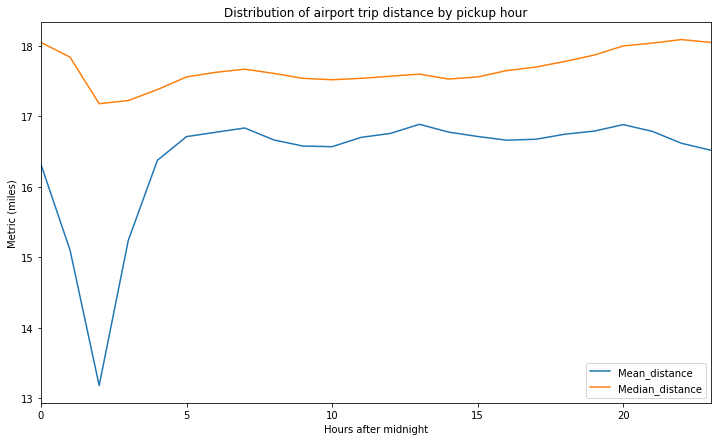

In [11]:
# CALCULATE AIRPORT TRIPS
airport_trips = taxi_dt[(taxi_dt.rate_code == 2) | (taxi_dt.rate_code ==3)]  #rate_code 2 and 3 are jfk and Newark respectively 
airport_trips['pickup_hour'] = airport_trips['pickup_time'].str[:2]

fix, axis = plt.subplots(1,1,figsize=(12,7))
#aggregate trip_distance by hour for plotting
tab = airport_trips.pivot_table(index='pickup_hour', values='trip_distance', aggfunc=('mean','median')).reset_index()  
tab.columns = ['Hour','Mean_distance','Median_distance']
tab[['Mean_distance','Median_distance']].plot(ax=axis)
plt.ylabel('Metric (miles)')
plt.xlabel('Hours after midnight')
plt.title('Distribution of airport trip distance by pickup hour')
plt.xlim([0,23])
plt.show()

This plot proves that the mean and the median of airport trips are almost similar during the days. Airport trips follow similar trend
where an increased number of long trips might be starting from many people coming to airport from further residential areas.

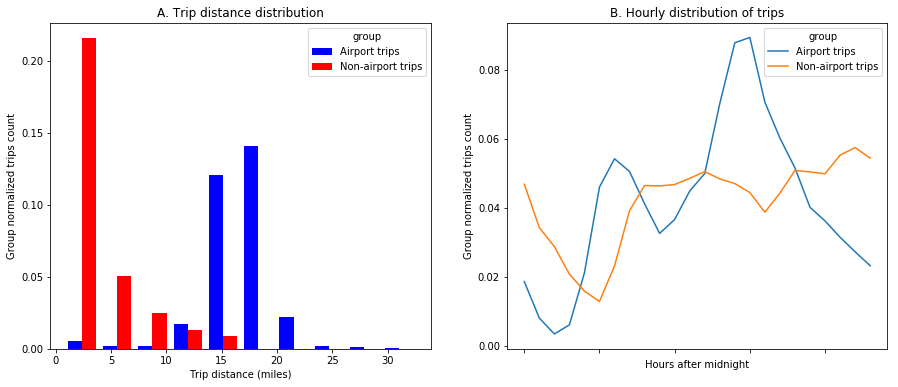

In [12]:
v_at = airport_trips.trip_distance #airport trips
v_nat = taxi_dt.loc[~taxi_dt.index.isin(v_at.index),'trip_distance'] #non-airport trips

#excluding any outliers (points that are more than 3 sd away)
v_at = v_at[~((v_at - v_at.median()).abs()>3*v_at.std())]
v_nat = v_nat[~((v_nat - v_nat.median()).abs()>3*v_nat.std())]

bins = np.histogram(v_at,normed=True)[1]
h_at = np.histogram(v_at,bins=bins,normed=True)
h_nat = np.histogram(v_nat,bins=bins,normed=True)


# plot distributions of trip distance normalized among groups
fig,ax = plt.subplots(1,2,figsize = (15,6))
w = .4*(bins[1]-bins[0])
ax[0].bar(bins[:-1],h_at[0],alpha=1,width=w,color='b')
ax[0].bar(bins[:-1]+w,h_nat[0],alpha=1,width=w,color='r')
ax[0].legend(['Airport trips','Non-airport trips'],loc='best',title='group')
ax[0].set_xlabel('Trip distance (miles)')
ax[0].set_ylabel('Group normalized trips count')
ax[0].set_title('A. Trip distance distribution')

# plot hourly distribution
airport_trips.pickup_hour.value_counts(normalize=True).sort_index().plot(ax=ax[1])
taxi_dt.loc[~taxi_dt.index.isin(v_at.index),'pickup_hour'].value_counts(normalize=True).sort_index().plot(ax=ax[1])
ax[1].set_xlabel('Hours after midnight')
ax[1].set_ylabel('Group normalized trips count')
ax[1].set_title('B. Hourly distribution of trips')
ax[1].legend(['Airport trips','Non-airport trips'],loc='best',title='group')
plt.show()

In [ ]:
DO PEOPLE LIKE TO TRAVEL IN GROUP/SHARE RIDES OR PREFER TO RIDE ALONE
Q: Are people more likely to travel in groups during holiday seasons?

Text(0.5,1,'Trips with number of passengers')

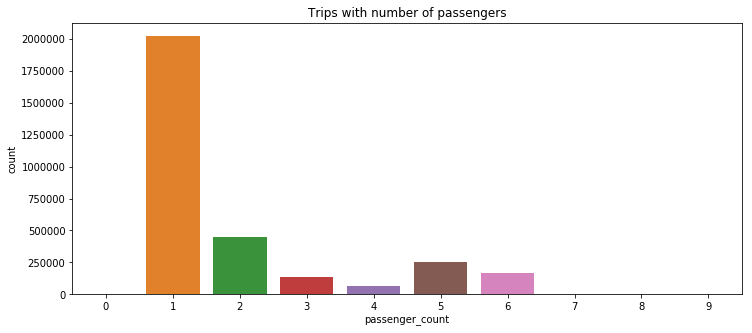

In [13]:
taxi_dt["pickup_month"] = pd.DatetimeIndex(taxi_dt['pickup_date']).month
jan_rides  = taxi_dt[(taxi_dt["pickup_month"] == 1)]
feb_rides  = taxi_dt[(taxi_dt["pickup_month"] == 2)]
mar_rides  = taxi_dt[(taxi_dt["pickup_month"] == 3)]
apr_rides  = taxi_dt[(taxi_dt["pickup_month"] == 4)]
may_rides  = taxi_dt[(taxi_dt["pickup_month"] == 5)]
jun_rides  = taxi_dt[(taxi_dt["pickup_month"] == 6)]
jul_rides  = taxi_dt[(taxi_dt["pickup_month"] == 7)]
aug_rides  = taxi_dt[(taxi_dt["pickup_month"] == 8)]
sep_rides  = taxi_dt[(taxi_dt["pickup_month"] == 9)]
oct_rides  = taxi_dt[(taxi_dt["pickup_month"] == 10)]
nov_rides  = taxi_dt[(taxi_dt["pickup_month"] == 11)]
dec_rides  = taxi_dt[(taxi_dt["pickup_month"] == 12)]

fig,ax = plt.subplots(1,1,figsize = (12,5))
s.countplot(x="passenger_count",data=taxi_dt)
plt.title('Trips with number of passengers')

about 2/3 of the total rides are single passenger rides. This seems to be working individuals. lets see how this trend looks like during
holiday season and if people are taking more group rides than single rides

Text(0.5,1,'Trips in December')

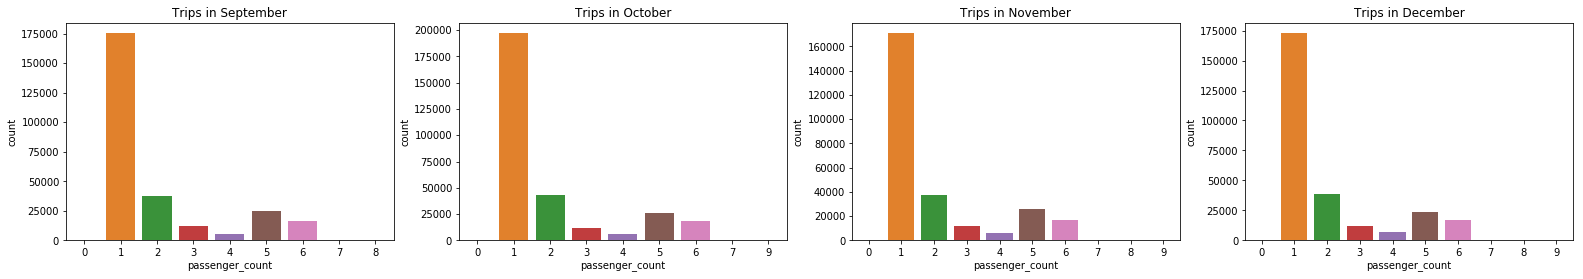

In [14]:
fig, axs = plt.subplots(1,4,figsize=(27,4))
s.countplot(x="passenger_count",data=jan_rides,ax=axs[0]).set_title("Trips in January")
s.countplot(x="passenger_count",data=feb_rides,ax=axs[1]).set_title("Trips in February")
s.countplot(x="passenger_count",data=mar_rides,ax=axs[2]).set_title("Trips in March")
s.countplot(x="passenger_count",data=apr_rides,ax=axs[3]).set_title("Trips in April")
s.countplot(x="passenger_count",data=may_rides,ax=axs[0]).set_title("Trips in May")
s.countplot(x="passenger_count",data=jun_rides,ax=axs[1]).set_title("Trips in June")
s.countplot(x="passenger_count",data=jul_rides,ax=axs[2]).set_title("Trips in July")
s.countplot(x="passenger_count",data=aug_rides,ax=axs[3]).set_title("Trips in August")
s.countplot(x="passenger_count",data=sep_rides,ax=axs[0]).set_title("Trips in September")
s.countplot(x="passenger_count",data=oct_rides,ax=axs[1]).set_title("Trips in October")
s.countplot(x="passenger_count",data=nov_rides,ax=axs[2]).set_title("Trips in November")
s.countplot(x="passenger_count",data=dec_rides,ax=axs[3]).set_title("Trips in December")

from the monthly passenger count plots, it looks like that most of the rides throughout the year were from single riders. There are
rides in 30-40k ranges which has more than one passengers. Interesting observation here is from January to August, we see that the most 
number of passengers are between 1-6 but in the last months and specifically in holiday seasons (november and december) there are many
rides with passenger count of upto 9. We do not see the numbers in chart because it is relatively smaller than smaller passenger rides but 
it is appearing in plot because it does exists there. This trend implies that during the holiday seasons, people are indeed traveling more
in groups compare to rest of the time.

TIP RATE AS FUNCTION OF TIME/LOCATION
Q: how does tipping rate change according to location and peak timing

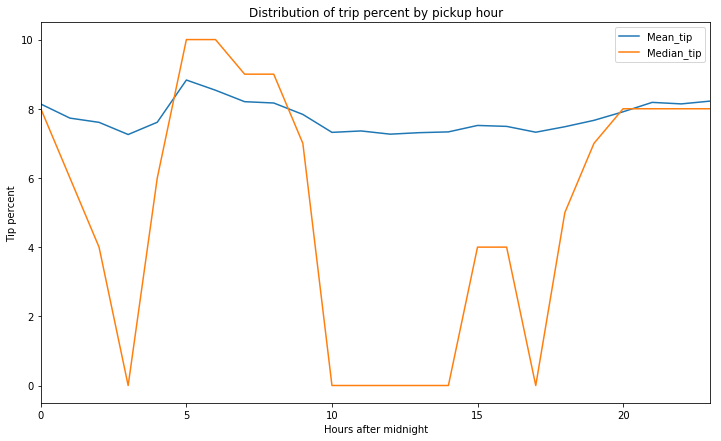

In [15]:
fix, axis = plt.subplots(1,1,figsize=(12,7))
#aggregate trip_distance by hour for plotting
taxi_dt["tip_percent"] = taxi_dt["tip_amount"] / taxi_dt["total_amount"] * 100

taxi_dt["tip_percent"].unique()
taxi_dt["tip_percent"] = taxi_dt["tip_percent"].replace(np.inf,0)
taxi_dt["tip_percent"] = taxi_dt["tip_percent"].replace(np.nan,0)
taxi_dt.tip_percent = taxi_dt.tip_percent.astype(np.int64)

tab = taxi_dt.pivot_table(index='pickup_hour', values='tip_percent', aggfunc=('mean','median')).reset_index()
     
tab.columns = ['Hour','Mean_tip','Median_tip']
tab[['Mean_tip','Median_tip']].plot(ax=axis)
plt.ylabel('Tip percent')
plt.xlabel('Hours after midnight')
plt.title('Distribution of trip percent by pickup hour')
plt.xlim([0,23])
plt.show()

From the chart, it looks like that riders are giving more tips during morning peak commute hours and in the night. At some point the 
median  tip is close to 0 but mean tip si considerably higher. This is because there are many trips with no tip at all and there is no data
available for certain rides. during the processing, we make those tip values to be 0. 

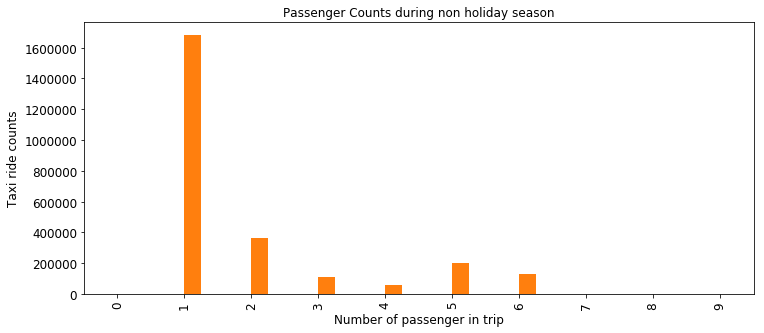

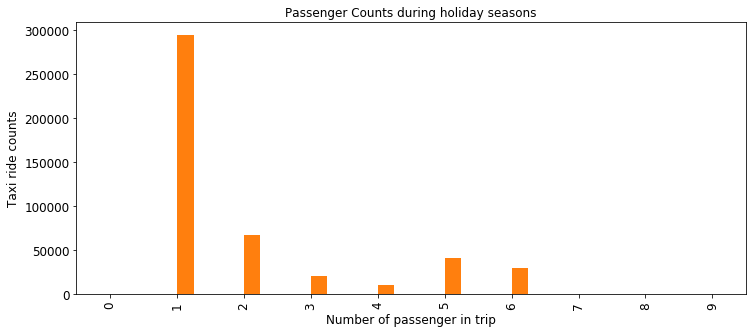

In [16]:
# TRAVEL IN TIME OF THE YEAR
holiday_dt = taxi_dt[(taxi_dt['pickup_date'] > '2013-01-01') & (taxi_dt['pickup_date'] < '2013-10-31')]
non_holiday_dt = taxi_dt[(taxi_dt['pickup_date'] > '2013-11-01') & (taxi_dt['pickup_date'] < '2013-12-31')]

holiday_rides = holiday_dt.groupby(['passenger_count']).size().reset_index(name='trip_count')
ax = holiday_rides.plot(kind='bar', title ="Passenger Counts during non holiday season", figsize=(12,5), legend=False, fontsize=12)
ax.set_xlabel("Number of passenger in trip", fontsize=12)
ax.set_ylabel("Taxi ride counts", fontsize=12)
plt.show()

non_holiday_ride = non_holiday_dt.groupby(['passenger_count']).size().reset_index(name='trip_count')
ax = non_holiday_ride.plot(kind='bar', title ="Passenger Counts during holiday seasons", figsize=(12,5), legend=False, fontsize=12)
ax.set_xlabel("Number of passenger in trip", fontsize=12)
ax.set_ylabel("Taxi ride counts", fontsize=12)
plt.show()

In [17]:
# check the derived variable 
taxi_dt.tip_percent.describe()

#we need to compare tip percent from manhatten island vs non-manhatten island
# get the coordinates of manhatten island from web to create a bounding box of territory
no_manhatten = [(40.796937, -73.949503),(40.787945, -73.955822),(40.782772, -73.943575),
              (40.794715, -73.929801),(40.811261, -73.934153),(40.835371, -73.934515),
              (40.868910, -73.911145),(40.872719, -73.910765),(40.878252, -73.926350),
              (40.850557, -73.947262),(40.836225, -73.949899),(40.806050, -73.971255)]

boundry = Polygon(no_manhatten)

#custom function to check if a rides is in manhatten or not
def is_manhatten(location,bound = boundry):
    return 1*(Point(location).within(boundry))

#createting new variable in dataset to check trip origin
taxi_dt["is_manhatten"] = taxi_dt[["pickup_lattitude","pickup_longtidue"]].apply(lambda m:is_manhatten((m[0],m[1])),axis=1)

#plot manhatten vs non-manhatten trips
non_manhatten = taxi_dt[(taxi_dt.is_manhatten==0) & (taxi_dt.tip_percent>0)].tip_percent
manhatten = taxi_dt[(taxi_dt.is_manhatten==1) & (taxi_dt.tip_percent>0)].tip_percent

bins = np.histogram(manhatten,bins=20)[1]
hist1 = np.histogram(manhatten,bins)
hist2 = np.histogram(non_manhatten,bins)

fig,axis = plt.subplots(1,1,figsize=(10,5))
w = .4*(bins[1]-bins[0])
axis.bar(bins[:-1],hist1[0],width=w,color='b')
axis.bar(bins[:-1]+w,hist2[0],width=w,color='r')
axis.set_yscale('log')
axis.set_xlabel('Tip percent')
axis.set_ylabel('Count')
axis.set_title('Tip')
axis.legend(['Non-Manhattan','Manhattah'],title='origin')
plt.show()

NameError: name 'Polygon' is not defined

In [19]:
print('t-test results:', ttest_ind(non_manhatten,manhatten,equal_var=False))

NameError: name 'ttest_ind' is not defined

In [20]:
#MOST COMMON PICKUP AND DROPOFF LOCATIONS
# Q: what are the frequent pickup and dropoff places and how do they relate to specific time of the year?
# register map api
api_key = ''
mplt.register_api_key(api_key)
taxi_map_pickup = taxi_dt[['pickup_longtidue','pickup_lattitude']]
taxi_map_pickup = taxi_map_pickup.rename(columns={'pickup_longtidue': 'longitude', 'pickup_lattitude': 'latitude'})
taxi_map_pickup = taxi_map_pickup.head(5000)
mplt.density_plot(taxi_map_pickup['latitude'], taxi_map_pickup['longitude'])

taxi_map_dropoff = taxi_dt[['dropoff_longitude','dropoff_lattitude','is_manhatten']]
taxi_map_dropoff = taxi_map_dropoff.rename(columns={'dropoff_longitude':'longitude','dropoff_lattitude':'latitude'})
taxi_map_dropoff = taxi_map_dropoff.head(5000)
mplt.density_plot(taxi_map_dropoff['latitude'], taxi_map_dropoff['longitude'])

NameError: name 'mplt' is not defined

from the pickup and drop location, it is clear that most of the trips are made in manhatten where density is extremely high. The other 
boroughs have trips too but may not be visible due to very less number of trips. The other locations that have high pickup and dropoff
densoties are jfk and laguardia airports that can be clearly seen from the map. You will also see that there have been many trips that 
initiated on the way to airport in queens borough.

#### Fature Engineering

1. trip directions:  Direction_NS (is the cab moving Northt to South?) and Direction_EW (is the cab moving East to West). 
    These are components of the two main directions, horizontal and vertical. The hypothesis is that the traffic may be different 
    in different directions and it may affect the riders enthousiasm to tipping. They were derived from pickup and dropoff coordinates.

In [21]:
#trip direction variable
# value of this variable will be 2 if ride is moving from north to south, 1 if moving from south to north and 0 otherewise
taxi_dt["trip_direction_NS"] = (taxi_dt.pickup_lattitude > taxi_dt.dropoff_lattitude)*1+1
indices = taxi_dt[(taxi_dt.pickup_lattitude == taxi_dt.dropoff_lattitude) & (taxi_dt.pickup_lattitude!=0)].index
taxi_dt.loc[indices,'trip_direction_NS'] = 0

# value of this variable will be 2 if ride is moving from east to west, 1 if moving from west to east and 0 otherewise
taxi_dt['trip_direction_EW'] = (taxi_dt.pickup_longtidue > taxi_dt.dropoff_longitude)*1+1
indices = taxi_dt[(taxi_dt.pickup_longtidue == taxi_dt.dropoff_longitude) & (taxi_dt.pickup_longtidue!=0)].index
taxi_dt.loc[indices,'trip_direction_EW'] = 0


#tip given variable
taxi_dt["tip_given"] = (taxi_dt.tip_percent > 0) * 1

aprt from these new features, we also already have build some during the exploratory data analysis that we think are going to be helpful
for our analysis.

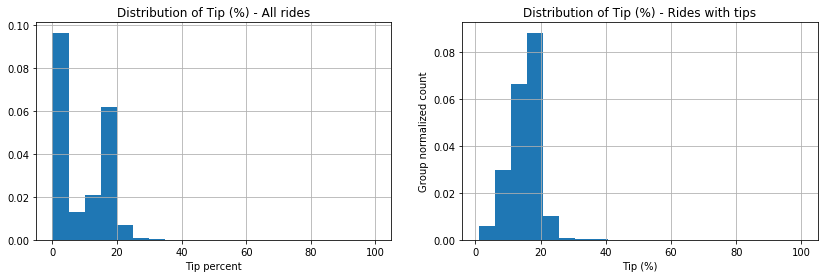

In [22]:
#compare tip vs non-tip data distribution
tip = taxi_dt[taxi_dt.tip_percent > 0]
no_tip = taxi_dt[taxi_dt.tip_percent == 0]

fig,axis = plt.subplots(1,2,figsize=(14,4))
taxi_dt.tip_percent.hist(bins = 20,normed=True,ax=axis[0])
axis[0].set_xlabel('Tip percent')
axis[0].set_title('Distribution of Tip (%) - All rides')

tip.tip_percent.hist(bins = 20,normed=True,ax=axis[1])
axis[1].set_xlabel('Tip (%)')
axis[1].set_title('Distribution of Tip (%) - Rides with tips')
axis[1].set_ylabel('Group normalized count')
plt.show()

In [23]:
#scatter plot of response variable with newly created predictors after feature engineering
taxi_features = tip[['trip_distance','rate_code','passenger_count','trip_time','payment_type','fare_amount','is_manhatten','tip_percent']]
taxi_pplot = s.pairplot(taxi_features)
taxi_pplot

KeyError: "['is_manhatten'] not in index"

In [28]:

# check relationship between response variable tip percent with other predictors
def visualize_continuous(dataframe,label,method={'type':'histogram','bins':20},outlier='on'):
    #placeholder for variable being checked
    var = dataframe[label]
    m = var.mean()
    s = var.std()
    
    #plot the figure
    fig,axis = plt.subplots(1,2,figsize=(14,4))
    axis[0].set_title('Distribution of '+label + '(trips where tips were given)')
    axis[1].set_title('Tip % by '+label)
    if outlier=='off': 
        var = var[(var-m)<=3*s]
        axis[0].set_title('Distribution of '+label+'(no outliers)')
        axis[1].set_title('Tip percent by '+label+'(no outliers)')
    if method['type'] == 'histogram':
        var.hist(bins = method['bins'],ax=axis[0])
    if method['type'] == 'boxplot': 
        dataframe.loc[var.index].boxplot(label,ax=axis[0])
    axis[1].plot(var,dataframe.loc[var.index].tip_percent,'.',alpha=0.3)
    axis[0].set_xlabel(label)
    axis[1].set_xlabel(label)
    axis[0].set_ylabel('Count')
    axis[1].set_ylabel('Tip percent')

In [29]:
#do the same with categorical variables
def visualize_categories(dataframe,label,chart_type='histogram',ylimit=[None,None]):
    #print label
    cats = sorted(pd.unique(dataframe[label]))
    if chart_type == 'boxplot': #generate boxplot
        create_boxplot(dataframe,label,ylimit)
    elif chart_type == 'histogram': # generate histogram
        create_histogram(dataframe,label)
    else:
        pass
    
    #=> calculate test statistics
    groups = dataframe[[label,'tip_percent']].groupby(label).groups #create groups
    tips = dataframe.tip_percent
    if len(cats)<=2: # if there are only two groups use t-test
        print(ttest_ind(tips[groups[cats[0]]],tips[groups[cats[1]]]))
    else: # otherwise, use one_way anova test
        # prepare the command to be evaluated
        cmd = "f_oneway("
        for cat in cats:
            cmd+="tips[groups["+str(cat)+"]],"
        cmd=cmd[:-1]+")"
        print("one way anova test:", eval(cmd)) #evaluate the command and print
    print("Frequency of categories (%):\n",dataframe[label].value_counts(normalize=True)*100)


In [30]:
def test_classification(df,label,yl=[0,50]):
    if len(pd.unique(df[label]))==2: #check if the variable is categorical with only two  categores and run chisquare test
        vals=pd.unique(df[label])
        gp1 = df[df.tip_given==0][label].value_counts().sort_index()
        gp2 = df[df.tip_given==1][label].value_counts().sort_index()
        print("t-test if", label, "can be used to distinguish transaction with tip and without tip")
        print(chisquare(gp1,gp2))
    elif len(pd.unique(df[label]))>=10: #other wise  run the t-test
        df.boxplot(label,by='tip_given')
        plt.ylim(yl)
        plt.show()
        print("t-test if", label, "can be used to distinguish transaction with tip and without tip")
        print("results:",ttest_ind(df[df.tip_given==0][label].values,df[df.tip_given==1][label].values,False))
    else:
        pass

In [31]:
def create_boxplot(dataframe,label,ylimit):
    dataframe.boxplot('tip_percent',by=label)
    plt.title('')
    pt.ylabel('Tip percent')
    if ylimit != [None,None]:
        plt.ylim(ylimit)
    plt.show()

In [32]:
def create_histogram(dataframe,label):
    cats = sorted(pd.unique(dataframe[label]))
    colors = plt.cm.jet(np.linspace(0,1,len(cats)))
    hx = np.array(map(lambda x:round(x,1),np.histogram(dataframe.tip_percent,bins=20)[1]))
    fig,ax = plt.subplots(1,1,figsize = (15,4))
    for i,cat in enumerate(cats):
        vals = dataframe[dataframe[label] == cat].tip_percent
        h = np.histogram(vals,bins=hx)
        w = 0.9*(hx[1]-hx[0])/float(len(cats))
        plt.bar(hx[:-1]+w*i,h[0],color=colors[i],width=w)
    plt.legend(cats)
    plt.yscale('log')
    plt.title('Distribution of Tip by '+label)
    plt.xlabel('Tip percent')
    

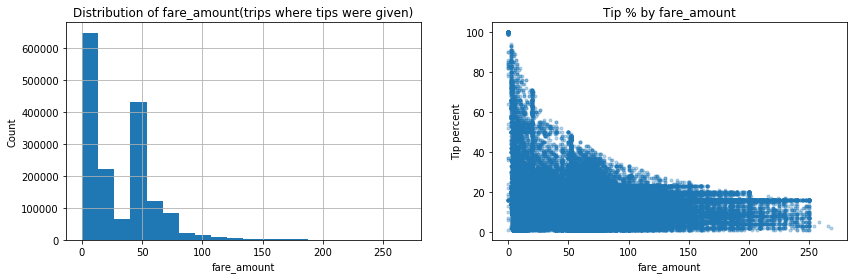

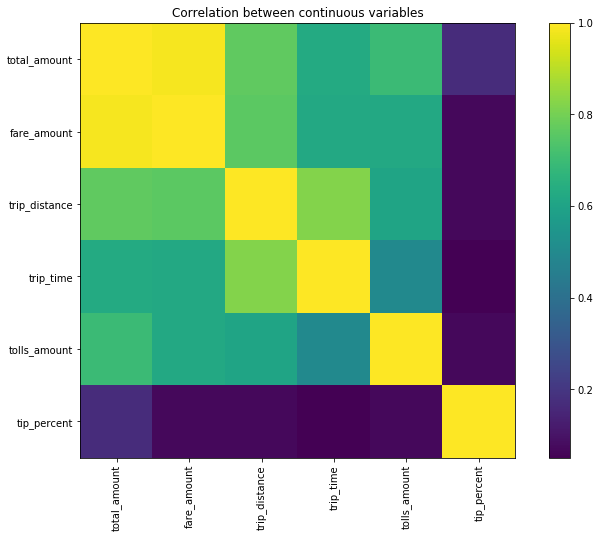

In [33]:
# Example of exploration of the Fare_amount using the implented code:
visualize_continuous(tip,'fare_amount',outlier='on')


#plot correlation map to find which predictors variables are correlated with each other
fig,ax = plt.subplots(1,1,figsize = [12,8])
continuous_variables=['total_amount','fare_amount','trip_distance','trip_time','tolls_amount','tip_percent']
cor_mat = taxi_dt[continuous_variables].corr()
plt.imshow(cor_mat)
plt.xticks(range(len(continuous_variables)),continuous_variables,rotation='vertical')
plt.yticks(range(len(continuous_variables)),continuous_variables)
plt.colorbar()
plt.title('Correlation between continuous variables')
plt.show()

TypeError: `bins` must be an integer, a string, or an array

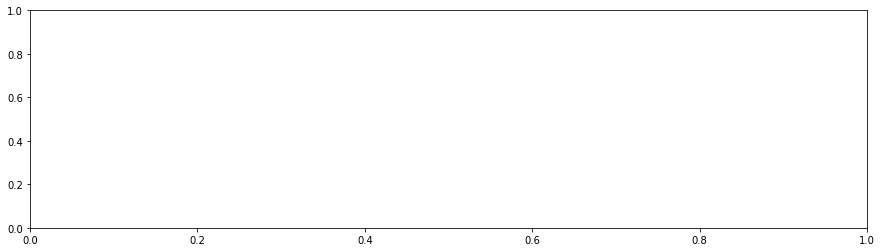

In [34]:
#check distribution with payment_type predictor
# visualization of the Payment_type
visualize_categories(tip,'payment_type','histogram',[13,8])

#### Building model

After feature engineering, we need to create model
we will build two models. First model will be classification model which will predict wheather or not passenger will give tip
Second model will be a regression model which will predict how much tip a passenger is likely to give (if he decises to give tip)

In [35]:
#MODEL: CLASSIFICATION MODEL 
# (passenger will give tip or not)
# test train split
predictors = ["rate_code","pickup_hour","pickup_month","trip_direction_NS","trip_direction_EW","passenger_count",
                    "trip_time","trip_distance","payment_type","fare_amount"]
X = taxi_dt[["rate_code","pickup_hour","pickup_month","trip_direction_NS","trip_direction_EW","passenger_count",
                    "trip_time","trip_distance","payment_type","fare_amount"]]

y = taxi_dt[["tip_given"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1121)

In [ ]:
def build_classification():
    
    print("building classification model...")
    t = dt.datetime.now()
    #optimize n_estimator thru gridsearch
    param_test = {'n_estimators':list(range(30,151,20))} 
    
    #create model
    print("\nfitting the model...")
    GBClassifier = GradientBoostingClassifier(
            learning_rate = 0.1,
            min_samples_split = 2,
            max_depth = 7,
            max_features ='auto',
            subsample = 0.7,
            random_state = 42
            )
    
    #fit the model
    print("\nhyper parameter search...")
    #hyper parameter search results thru cross validation
    gb_gs = GridSearchCV(estimator = GBClassifier, param_grid = param_test, scoring='roc_auc', n_jobs = -1, cv = 5)
    print(("\nfitting the model..."))
    gb_gs.fit(X_train,y_train)
    print("\nfinished model training...")
    print(gb_gs.best_score_)
    print(gb_gs.best_params_)
    
    gb_gs.best_params_.fit(X_train,y_train)
    
    #make predictions
    print("\nmaking predictions...")
    Predicted = gb_gs.best_params_.predict(X_train.as_matrix())
    
    #accuracies
    #Predicted.size
    #y_test.as_matrix().size
    #np.mean(Predicted == y_test.as_matrix())
    PredictedProb = gb_gs.best_params_.predict_proba(X_train.as_matrix())
    PredictedProb[:,1]

    #cross-validation
    print("\ncross validation on model...")
    gb_cv = cross_validation.cross_val_score(gb_gs.best_params_,X_train.as_matrix(),y_train.as_matrix(), cv=5,scoring='roc_auc')

    print("\nchecking model performance...")
    #model performance report
    print("\nModel accuracy:", metrics.accuracy_score(y_train.values,Predicted))
    print("\nAUC Score (from train set):",metrics.roc_auc_score(y_train,PredictedProb))
    print("\nCV Score - Mean : %.7g | Std : %.7g | Min : %.7g | Max : %.7g" % (np.mean(gb_cv),np.std(gb_cv),np.min(gb_cv),np.max(gb_cv)))

    print("\ncalculating most importance features of the model...")
    #print feature importance for model
    fig,ax = plt.subplots(1,1,figsize = [12,8])
    imp_features = pd.Series(GBClassifier.feature_importances_,predictors).sort_values(ascending=False)
    imp_features.plot(kind='bar',title='Feature Importance for classification model')
    plt.ylabel('Feature Importance Score')
    plt.show()
    print("\nThe most importance features for classification model (In order of importance)...")
    print(imp_features)

    print("\ntotal processing time: ", dt.datetime.now() - t)

In [ ]:
build_classification()

In [36]:
def build_regression():
     print("\nbuilding regression model...")
     print("\nread the data...")
     t = dt.datetime.now()
     
     param_test = {'n_estimators':range(50,200,25)}
     
     #fit the regression model
     RFRegressor = RandomForestRegressor()
     
     print("\nhyper parameter search...")
     RFRegressor_gs = GridSearchCV(estimator=RFRegressor, param_grid = param_test,n_jobs = -1,cv = 5)
     print("\nfitting regression...")
     RFRegressor_gs.fit(X_train.as_matrix(),y_train.as_matrix().ravel())
     print(RFRegressor_gs.best_score_)
     print(RFRegressor_gs.best_params_)
     
     RFRegressor_gs.best_params_.fit(X_train.as_matrix(),y_train.as_matrix().ravel())

     #make prediction
     print("\nmaking prediction on train data...")
     Predicted = RFRegressor_gs.best_params_.predict(X_train.as_matrix())
    
     print("\nperforming cross validation...")
     #cross-validation
     rf_cv = cross_validation.cross_val_score(RFRegressor_gs.best_params_,X_train.as_matrix(),y_train.as_matrix(), cv=10,scoring='mean_squared_error')
    
     #model performance statistics
     print("\nchecking model performance...")
     print("\nModel mean suqared error:",metrics.mean_squared_error(y_train.values,Predicted))
     print("\nCV Score - Mean : %.7g | Std : %.7g | Min : %.7g | Max : %.7g" % (np.mean(rf_cv),np.std(rf_cv),np.min(rf_cv),np.max(rf_cv)))

     print("\ncalculate most important features...")
     #print feature importance for model
     fig,ax = plt.subplots(1,1,figsize = [12,8])
     imp_features = pd.Series(RFRegressor_gs.best_params_.feature_importances_,predictors).sort_values(ascending=False)
     imp_features.plot(kind='bar',title='Feature Importance for Regression model')
     plt.ylabel('Feature Importance Score')
     plt.show()
     print("\nThe most importance features for regression in (In order of importance)...")
     print(imp_features)

     print("\ntotal processing time: ",dt.datetime.now() - t)

In [37]:
build_regression()


building regression model...

read the data...

hyper parameter search...

fitting regression...


KeyboardInterrupt: 

In [ ]:
# random stuff for own testing
y = taxi_dt.fare_amount
x = taxi_dt[['vendor_id','rate_code','passenger_count','payment_type']]
test_frame = taxi_dt[['trip_distance','rate_code','passenger_count','trip_time','payment_type','fare_amount']]

taxi_df = pd.concat([x,y], axis=1)

scat_mat = pd.plotting.scatter_matrix(x, c=y,marker='o', hist_kwds={'bins':100}, s=100,alpha=0.7)
plt.tight_layout()
#plt.savefig('scat_mat.png')

plot = s.pairplot(test_frame)
plot

KeyboardInterrupt: 